In [1]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.3 MB/s eta 0:00:00


In [2]:
import torch
import triton
import triton.language as tl

In [3]:
def get_autotune_config():
    return [
        triton.Config(
            {"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 256, "BLOCK_SIZE_K": 64},
            num_stages=3,
            num_warps=8,
        ),
        triton.Config(
            {"BLOCK_SIZE_M": 64, "BLOCK_SIZE_N": 256, "BLOCK_SIZE_K": 32},
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 128, "BLOCK_SIZE_K": 32},
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 64, "BLOCK_SIZE_K": 32},
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {"BLOCK_SIZE_M": 64, "BLOCK_SIZE_N": 128, "BLOCK_SIZE_K": 32},
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {"BLOCK_SIZE_M": 128, "BLOCK_SIZE_N": 32, "BLOCK_SIZE_K": 32},
            num_stages=4,
            num_warps=4,
        ),
        triton.Config(
            {"BLOCK_SIZE_M": 64, "BLOCK_SIZE_N": 32, "BLOCK_SIZE_K": 32},
            num_stages=5,
            num_warps=2,
        ),
        triton.Config(
            {"BLOCK_SIZE_M": 32, "BLOCK_SIZE_N": 64, "BLOCK_SIZE_K": 32},
            num_stages=5,
            num_warps=2,
        ),
    ]

In [4]:
@triton.autotune(
    configs=get_autotune_config(),
    key=["K"],
)
@triton.jit
def matmul_kernel(
    a_ptr,
    b_ptr,
    c_ptr,
    M,
    N,
    K,
    stride_am,
    stride_ak,
    stride_bk,
    stride_bn,
    stride_cm,
    stride_cn,
    GROUP_SIZE_M: tl.constexpr,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    c = accumulator.to(tl.float16)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)

In [5]:
def matmul(a, b, GSM):
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape

    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (
        triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]),
    )
    matmul_kernel[grid](
        a,
        b,
        c,
        M,
        N,
        K,
        a.stride(0),
        a.stride(1),
        b.stride(0),
        b.stride(1),
        c.stride(0),
        c.stride(1),
        GSM,
    )
    return c

In [6]:
configs = [
    triton.testing.Benchmark(
        x_names=["K"],
        x_vals=[i for i in range(512, 8193, 512)],
        line_arg="provider",
        line_vals=["cublas", "triton"],
        line_names=["cuBLAS", "Triton"],
        styles=[("green", "-"), ("blue", "-")],
        ylabel="Time (ms)",
        plot_name=f"matmul-performance-fp16-{GSM}",
        args={
            "M": 8192,
            "N": 8192,
            "GSM": GSM,
        },
    )
    for GSM in [2**i for i in range(10)]
]


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, GSM):
    a = torch.randn((M, K), device="cuda", dtype=torch.float16)
    b = torch.randn((K, N), device="cuda", dtype=torch.float16)
    if provider == "cublas":
        ms = triton.testing.do_bench(lambda: torch.matmul(a, b))
    elif provider == "triton":
        ms = triton.testing.do_bench(lambda: matmul(a, b, GSM))

    return ms


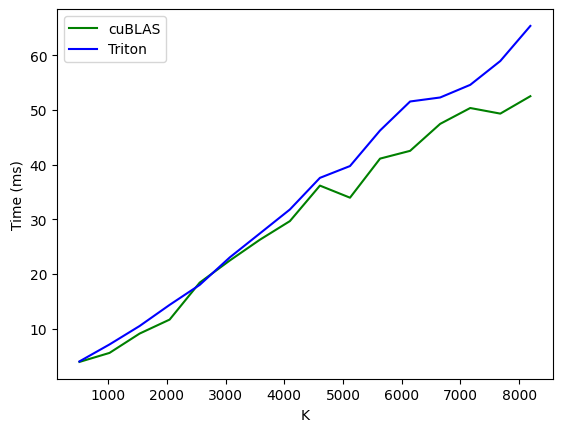

matmul-performance-fp16-1:
         K     cuBLAS     Triton
0    512.0   3.939434   4.033386
1   1024.0   5.588170   7.134127
2   1536.0   9.119249  10.503621
3   2048.0  11.683317  14.373152
4   2560.0  18.442457  18.026047
5   3072.0  22.484489  23.052336
6   3584.0  26.280769  27.431084
7   4096.0  29.692223  31.816446
8   4608.0  36.188225  37.604240
9   5120.0  33.976898  39.763870
10  5632.0  41.123409  46.267967
11  6144.0  42.546593  51.572769
12  6656.0  47.479103  52.305664
13  7168.0  50.379520  54.616161
14  7680.0  49.354752  58.974239
15  8192.0  52.539360  65.393341


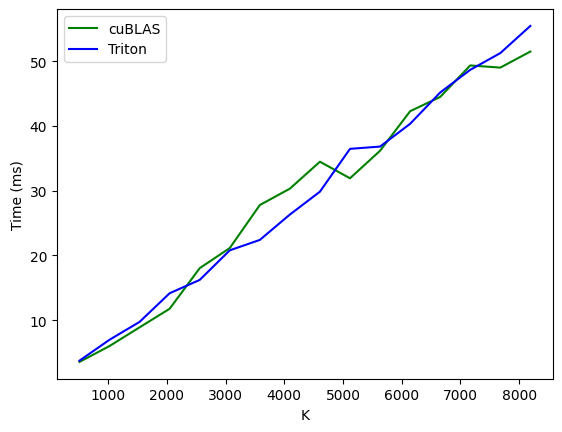

matmul-performance-fp16-2:
         K     cuBLAS     Triton
0    512.0   3.546133   3.737571
1   1024.0   6.001165   6.969528
2   1536.0   8.887856   9.731864
3   2048.0  11.760320  14.159604
4   2560.0  18.031059  16.217220
5   3072.0  21.141544  20.790321
6   3584.0  27.786390  22.399916
7   4096.0  30.321291  26.318666
8   4608.0  34.486256  29.856344
9   5120.0  31.924015  36.472771
10  5632.0  36.175888  36.824543
11  6144.0  42.285648  40.341953
12  6656.0  44.493359  45.176819
13  7168.0  49.360832  48.682335
14  7680.0  49.028000  51.269665
15  8192.0  51.504959  55.468288


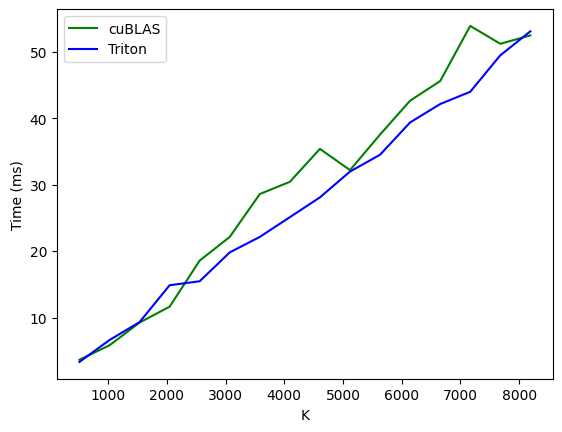

matmul-performance-fp16-4:
         K     cuBLAS     Triton
0    512.0   3.641996   3.312196
1   1024.0   5.814200   6.608022
2   1536.0   9.238417   9.305756
3   2048.0  11.629881  14.859531
4   2560.0  18.573767  15.460390
5   3072.0  22.136314  19.805607
6   3584.0  28.592108  22.138096
7   4096.0  30.431114  25.108810
8   4608.0  35.391586  28.088354
9   5120.0  32.189327  31.971933
10  5632.0  37.546547  34.509457
11  6144.0  42.650673  39.372974
12  6656.0  45.600723  42.140976
13  7168.0  53.905056  43.989090
14  7680.0  51.213886  49.479168
15  8192.0  52.475903  53.092354


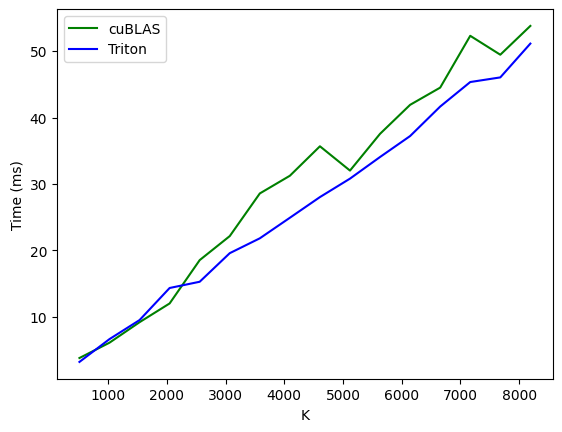

matmul-performance-fp16-8:
         K     cuBLAS     Triton
0    512.0   3.771469   3.182758
1   1024.0   6.080936   6.621591
2   1536.0   9.167303   9.486288
3   2048.0  11.992592  14.319136
4   2560.0  18.518623  15.258784
5   3072.0  22.136105  19.564329
6   3584.0  28.560778  21.801760
7   4096.0  31.226900  24.898977
8   4608.0  35.665199  28.013184
9   5120.0  32.005119  30.793215
10  5632.0  37.545074  34.052208
11  6144.0  41.908798  37.208015
12  6656.0  44.501808  41.648354
13  7168.0  52.307678  45.343330
14  7680.0  49.457279  46.040733
15  8192.0  53.795456  51.133282


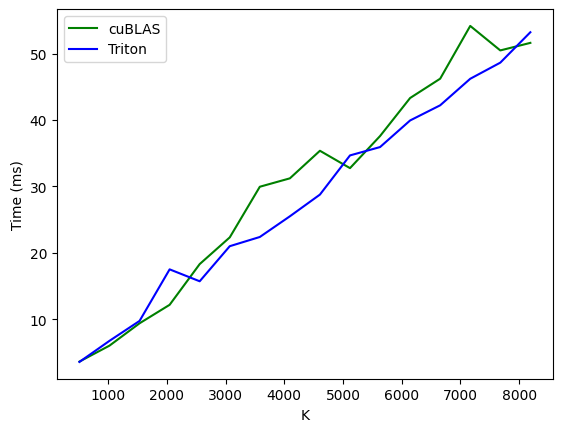

matmul-performance-fp16-16:
         K     cuBLAS     Triton
0    512.0   3.624437   3.575047
1   1024.0   6.029724   6.753219
2   1536.0   9.392098   9.750504
3   2048.0  12.175104  17.513674
4   2560.0  18.308384  15.718867
5   3072.0  22.328625  21.000919
6   3584.0  29.953386  22.388281
7   4096.0  31.218657  25.503424
8   4608.0  35.371727  28.772535
9   5120.0  32.755615  34.671520
10  5632.0  37.587662  35.929119
11  6144.0  43.315456  39.935345
12  6656.0  46.225151  42.217506
13  7168.0  54.170689  46.212753
14  7680.0  50.480511  48.639999
15  8192.0  51.618881  53.221375


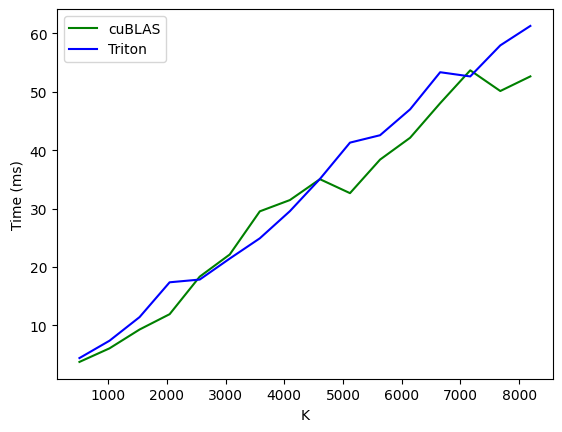

matmul-performance-fp16-32:
         K     cuBLAS     Triton
0    512.0   3.744337   4.402453
1   1024.0   6.070315   7.375746
2   1536.0   9.293536  11.421654
3   2048.0  11.920504  17.382551
4   2560.0  18.345039  17.847727
5   3072.0  22.148081  21.444881
6   3584.0  29.533609  24.913269
7   4096.0  31.464149  29.561804
8   4608.0  35.040833  35.081841
9   5120.0  32.648048  41.303665
10  5632.0  38.393997  42.568993
11  6144.0  42.136288  47.005646
12  6656.0  48.056129  53.360481
13  7168.0  53.685726  52.640385
14  7680.0  50.140926  57.956512
15  8192.0  52.645695  61.290112


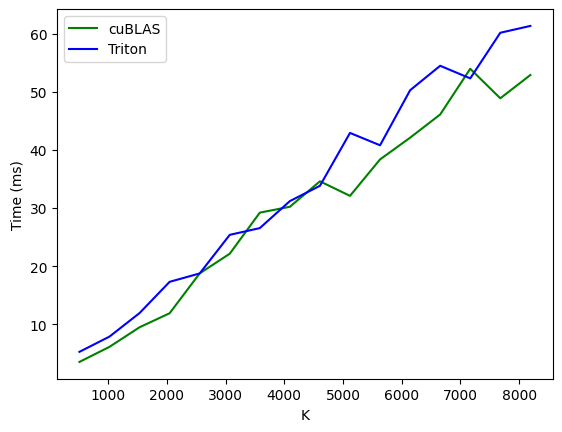

matmul-performance-fp16-64:
         K     cuBLAS     Triton
0    512.0   3.532454   5.266257
1   1024.0   6.129448   7.891550
2   1536.0   9.495852  11.939857
3   2048.0  11.905124  17.311359
4   2560.0  18.764839  18.751841
5   3072.0  22.147610  25.391830
6   3584.0  29.210091  26.551466
7   4096.0  30.222570  31.196768
8   4608.0  34.601662  33.826157
9   5120.0  32.097439  42.924431
10  5632.0  38.368385  40.799168
11  6144.0  42.104832  50.267807
12  6656.0  46.096306  54.474495
13  7168.0  53.958687  52.306305
14  7680.0  48.879646  60.154270
15  8192.0  52.885311  61.330017


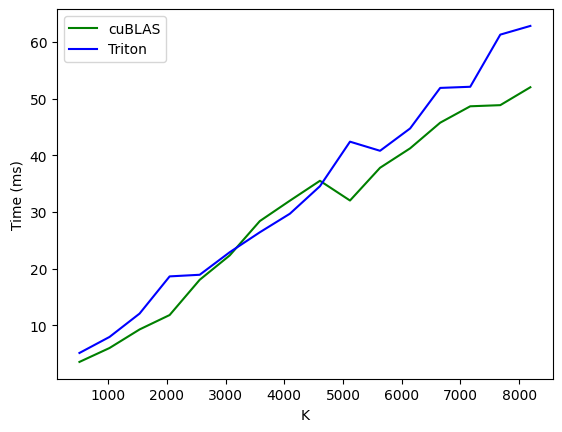

matmul-performance-fp16-128:
         K     cuBLAS     Triton
0    512.0   3.534227   5.115500
1   1024.0   5.989517   7.944144
2   1536.0   9.266842  12.066729
3   2048.0  11.812840  18.634548
4   2560.0  18.030369  18.919552
5   3072.0  22.343241  22.905546
6   3584.0  28.398613  26.420256
7   4096.0  31.999445  29.698229
8   4608.0  35.511581  34.554081
9   5120.0  32.028866  42.418255
10  5632.0  37.809357  40.808479
11  6144.0  41.240349  44.752159
12  6656.0  45.766594  51.908066
13  7168.0  48.664577  52.110497
14  7680.0  48.865250  61.317150
15  8192.0  52.026562  62.852833


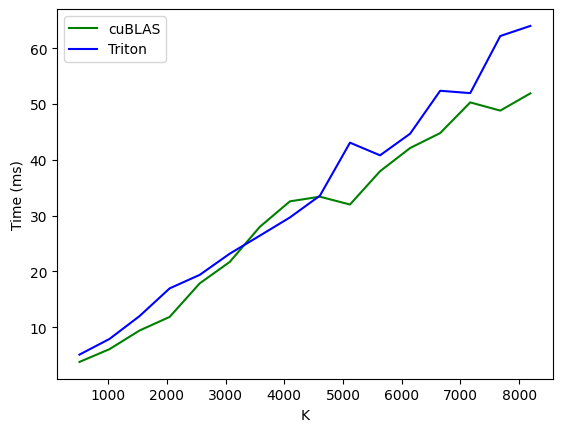

matmul-performance-fp16-256:
         K     cuBLAS     Triton
0    512.0   3.769784   5.078803
1   1024.0   6.059166   7.890795
2   1536.0   9.402830  11.989984
3   2048.0  11.836487  16.951239
4   2560.0  17.848282  19.371544
5   3072.0  21.694511  23.174814
6   3584.0  27.981279  26.399475
7   4096.0  32.552227  29.661621
8   4608.0  33.385933  33.573166
9   5120.0  31.984659  43.070160
10  5632.0  37.953457  40.801247
11  6144.0  42.110065  44.679073
12  6656.0  44.788239  52.374271
13  7168.0  50.288864  51.952641
14  7680.0  48.820225  62.189217
15  8192.0  51.906944  63.997921


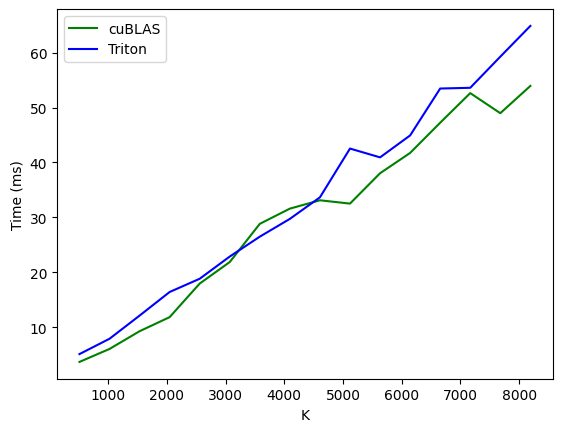

matmul-performance-fp16-512:
         K     cuBLAS     Triton
0    512.0   3.682303   5.107628
1   1024.0   6.043299   7.900370
2   1536.0   9.271799  12.116252
3   2048.0  11.838237  16.416454
4   2560.0  17.951872  18.827423
5   3072.0  21.869738  22.873215
6   3584.0  28.826956  26.495508
7   4096.0  31.599497  29.731956
8   4608.0  33.116142  33.655487
9   5120.0  32.513000  42.537056
10  5632.0  38.039246  40.931007
11  6144.0  41.738686  44.925438
12  6656.0  47.241615  53.466846
13  7168.0  52.633022  53.602081
14  7680.0  48.977951  59.268162
15  8192.0  53.939617  64.868256


In [7]:
benchmark.run(print_data=True, show_plots=True)